In [190]:
import io
import re
import pandas as pd
import urllib
import random
import numpy as np
import matplotlib.pyplot as plt

from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Flatten, Embedding, Conv1D, MaxPooling1D

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

Reading the dataset and choosing the features

In [191]:
normal_traffic1 = './dataset/normalTrafficTraining.txt'
normal_traffic2 = './dataset/normalTrafficTest.txt'
anomalous_traffic = './dataset/anomalousTrafficTest.txt'

In [192]:
# helper function to convert ["key:value"] to {"key":"value"}
def list_to_dict(list_of_dicts):
    return dict(map(lambda s : s.split(':'), list_of_dicts))

In [193]:
# This function serves to convert the dataset to a pandas dataframe where each
# column corresponds to http header fields

def get_features(file_in):
    fin = open(file_in)
    lines = fin.readlines()
    features = []
    data = []
    full_dict = {} # final dictionary that will be converted to DataFrame
    i = 0
    while (i < len(lines)):
        line = lines[i].strip()
        if (line.startswith("GET") or line.startswith("POST") or line.startswith("PUT")):
            if len(features) == 0:
                method = line.split(' ')[0]
            if len(features) != 0:
                features.append("Method: " + method)
                dict_features = list_to_dict(features)
                data.append(dict_features)
                features = []
                method = line.split(' ')[0]
        elif line.startswith("Content-Length") :
            features.append(line)
            i += 2
        elif line.startswith("Host"):
            host = line.split(':')[2]
            features.append("Host: " + host)
        elif line:
            features.append(line)
        i += 1
    
    # including the last line
    features.append("Method: " + method)
    dict_features = list_to_dict(features)
    data.append(dict_features)
    # converting the list of dictionaries to a final dictionary (that will be converted to DataFrame)
    i = 0
    for entry in data:
        # add a dictionary entry to the final dictionary
        if "Content-Length" in entry: # POST and PUT cases
            full_dict[i] = {"method": entry['Method'], "user_agent": entry['User-Agent'], "pragma": entry['Pragma'], "cookie": entry['Cookie'],
                            "cache_control": entry['Cache-control'], "accept": entry['Accept'], "accept_encoding": entry['Accept-Encoding'], 
                            "accept_char": entry['Accept-Charset'], "accept_lang": entry['Accept-Language'], "host": entry['Host'], 
                            "connection": entry["Connection"], "content_type": entry['Content-Type'], "content_len": entry['Content-Length']}
        else: # GET case
            full_dict[i] = {"method": entry['Method'], "user_agent": entry['User-Agent'], "pragma": entry['Pragma'], "cookie": entry['Cookie'],
                            "cache_control": entry['Cache-control'], "accept": entry['Accept'], "accept_encoding": entry['Accept-Encoding'], 
                            "accept_char": entry['Accept-Charset'], "accept_lang": entry['Accept-Language'], "host": entry['Host'], 
                            "connection": entry["Connection"], "content_type": 'NULL', "content_len": 'NULL'}

        i = i + 1
    
    #converting to Dataframe
    df_features = pd.DataFrame.from_dict(full_dict, orient="index")
    fin.close()
    return df_features

In [194]:
df_normal = get_features(normal_traffic1)
df_normal = pd.concat([df_normal, get_features(normal_traffic2)])
df_normal

,method,user_agent,pragma,cookie,cache_control,accept,accept_encoding,accept_char,accept_lang,host,connection,content_type,content_len
0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
1,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
2,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=933185092E0B668B90676E0A2B0767AF,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,application/x-www-form-urlencoded,68
3,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
4,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,application/x-www-form-urlencoded,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=E1E16AC490F40B8484CD75E2DBE32075,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
35996,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=4567793E184E0925234DADCEECD6999A,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
35997,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=487FD70FECB4D14155C95F38C389DA0D,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
35998,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=6E0F5F3BC982DFC73B39EAD495ADCE96,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL


In [195]:
df_anomalous = get_features(anomalous_traffic)
df_anomalous

,method,user_agent,pragma,cookie,cache_control,accept,accept_encoding,accept_char,accept_lang,host,connection,content_type,content_len
0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
1,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=AE29AEEBDE479D5E1A18B4108C8E3CE0,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,application/x-www-form-urlencoded,146
2,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=F563B5262843F12ECAE41815ABDEEA54,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
3,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=3B654D6DF7F1466EE80D7F756B00E5D1,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,application/x-www-form-urlencoded,77
4,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=51A7470173188BBB993947F2283059E4,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25060,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
25061,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,application/x-www-form-urlencoded,255
25062,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
25063,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL


In [196]:
pd.crosstab(df_normal.content_type, df_normal.method) # NULL if GET method

method,GET,POST
content_type,,
application/x-www-form-urlencoded,0,16000
NULL,56000,0


In [197]:
pd.crosstab(df_anomalous.accept, df_anomalous.method) # depends only on PUT method

method,GET,POST,PUT
accept,,,
"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5",15088,9580,0
"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5",0,0,397


In [198]:
pd.crosstab(df_anomalous.host, df_anomalous.method) # depends only on PUT method

method,GET,POST,PUT
host,,,
8080,15088,9580,0
9090,0,0,397


Getting the method field and the message body

In [199]:
def get_method_msgbody(file_in):
    fin = open(file_in)
    lines = fin.readlines()
    method_msgbody = []
    for i in range(len(lines)):
        line = lines[i].strip()
        
        if line.startswith("GET"):
            url = line.split(" ")[1]
            url = urllib.parse.unquote(urllib.parse.unquote(url)).replace('\n','')
            # decoded_url = urllib.parse.unquote(url) #decoding the %xx escapes
            # double_decoded_url = urllib.parse.unquote(decoded_url)
            # symbols = r"[/@<>.?=&()]"
            method_msgbody.append(url)
        elif (line.startswith("POST") or line.startswith("PUT")):
            method = line.split(" ")[0]
            url = line.split(" ")[1]
            
            #merging the query to the method field
            j = 1
            while True:
                if lines[i + j].startswith("Content-Length"):
                    break
                j += 1
            j += 1
            data = lines[i + j + 1].strip()
            url += '?' + data
            url = urllib.parse.unquote(urllib.parse.unquote(url)).replace('\n','')
            #decoded_url = urllib.parse.unquote(url)
            #double_decoded_url = urllib.parse.unquote(decoded_url)
            method_msgbody.append(url)
    fin.close()
    return method_msgbody

In [200]:
#generating a dataframe for normal requests (we merge train and test data)
normal_requests1 = get_method_msgbody(normal_traffic1)
normal_requests2 = get_method_msgbody(normal_traffic2)
df_normal_requests = pd.concat([pd.DataFrame(normal_requests1), pd.DataFrame(normal_requests2)])
df_normal_requests.rename(columns = {0: 'requests'}, inplace=True)
df_normal_requests.drop_duplicates(inplace=True) #get rid of all the duplicates
# df_normal_requests["labels"] = 0

df_normal_requests.to_csv("./dataset/test.txt", sep='\t', index=False)
df_normal_requests

,requests
0,http://localhost:8080/tienda1/index.jsp
1,http://localhost:8080/tienda1/publico/anadir.j...
3,http://localhost:8080/tienda1/publico/autentic...
5,http://localhost:8080/tienda1/publico/caracter...
7,http://localhost:8080/tienda1/publico/carrito.jsp
...,...
35965,http://localhost:8080/tienda1/publico/anadir.j...
35967,http://localhost:8080/tienda1/publico/autentic...
35975,http://localhost:8080/tienda1/publico/pagar.js...
35978,http://localhost:8080/tienda1/publico/registro...


In [201]:
#generating a dataframe for anomalous requests
anomalous_requests = get_method_msgbody(anomalous_traffic)
df_anomalous_requests = pd.DataFrame(anomalous_requests)
df_anomalous_requests.rename(columns = {0: 'requests'}, inplace=True)
df_anomalous_requests.drop_duplicates(inplace=True)
df_anomalous_requests["labels"] = 1
df_anomalous_requests

,requests,labels
0,http://localhost:8080/tienda1/publico/anadir.j...,1
2,http://localhost:8080/tienda1/publico/anadir.j...,1
4,http://localhost:8080/asf-logo-wide.gif~,1
5,http://localhost:8080/tienda1/publico/autentic...,1
7,http://localhost:8080/tienda1/publico/autentic...,1
...,...,...
25050,http://localhost:8080/tienda1/global.BAK,1
25055,http://localhost:8080/tienda1/miembros/editar....,1
25056,http://localhost:8080/tienda1/miembros/editar....,1
25058,http://localhost:8080/tienda1/miembros/editar....,1


In [202]:
def splitting(df):
    for index, row in df.iterrows():
        url = row['requests']
        
        separated_url = re.sub(r'([/?&=<>:.@+-])', r' \1 ', url)

        df.at[index, 'requests'] = separated_url
    return df
    

In [203]:
new_df_anomalous_request = splitting(df_anomalous_requests)

# official_df_anomalous_request.drop('labels')\
new_df_anomalous_request
# new_df_anomalous_request.to_csv("./dataset/test2.txt", sep='\t', index=False)

,requests,labels
0,http : / / localhost : 8080 / tienda1 / publ...,1
2,http : / / localhost : 8080 / tienda1 / publ...,1
4,http : / / localhost : 8080 / asf - logo - w...,1
5,http : / / localhost : 8080 / tienda1 / publ...,1
7,http : / / localhost : 8080 / tienda1 / publ...,1
...,...,...
25050,http : / / localhost : 8080 / tienda1 / glob...,1
25055,http : / / localhost : 8080 / tienda1 / miem...,1
25056,http : / / localhost : 8080 / tienda1 / miem...,1
25058,http : / / localhost : 8080 / tienda1 / miem...,1


In [204]:
new_df_normal_request = splitting(df_normal_requests)
new_df_normal_request
new_df_normal_request.to_csv("./dataset/test1.csv", sep='\t', index=False)

In [205]:
normal_data = new_df_normal_request
anomalous_data = new_df_anomalous_request

# normal_data = normal_data.values
train_normal_data, test_normal_data = train_test_split(normal_data, test_size=0.2, random_state=42)


train_anomalous_data, test_anomalous_data = train_test_split(anomalous_data, test_size=0.2, random_state=42)

normal_data

,requests
0,http : / / localhost : 8080 / tienda1 / inde...
1,http : / / localhost : 8080 / tien...
3,http : / / localhost : 8080 / tien...
5,http : / / localhost : 8080 / tienda1 / publ...
7,http : / / localhost : 8080 / tienda1 / publ...
...,...
35965,http : / / localhost : 8080 / tien...
35967,http : / / localhost : 8080 / tien...
35975,http : / / localhost : 8080 / tien...
35978,http : / / localhost : 8080 / tien...


In [206]:
normal_sentence = normal_data['requests'].tolist()

w2v_train = [sentence.split() for sentence in normal_sentence]
w2v_model = Word2Vec(vector_size=300, window=3, min_count=20, workers=8, sg=1)

w2v_model.build_vocab(w2v_train, progress_per=10000)

w2v_model.train(normal_sentence, total_examples=w2v_model.corpus_count, epochs=10, report_delay=1)

# w2v_model = Word2Vec(normal_sentence, vector_size=128, window=5, min_count=20, workers=8, sg=1)
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))
print(w2v_model.wv.most_similar('localhost', topn=10))
print(w2v_model.wv.most_similar('8080', topn=10))
print(w2v_model.wv.most_similar('login', topn=10))
w2v_model.save('w2v.model')
w2v_model = Word2Vec.load('w2v.model')

Vocabulary Size: 343 - Embedding Dim: 300
[('Guadalajara', 0.1735888421535492), ('Avda', 0.13146881759166718), ('Don', 0.12871471047401428), ('90', 0.12867474555969238), ('sh', 0.12640579044818878), ('sd', 0.12412934750318527), ('bn', 0.12013346701860428), ('17', 0.1187221109867096), ('so', 0.10955345630645752), ('Granada', 0.10709134489297867)]
[('12', 0.16923794150352478), ('dz', 0.15172359347343445), ('Asturias', 0.1481235921382904), ('de', 0.13868547976016998), ('C�diz', 0.1362038552761078), ('je', 0.13426990807056427), ('Vizcaya', 0.13152280449867249), ('gs', 0.12192575633525848), ('40', 0.11706274002790451), ('Paseo', 0.11702128499746323)]
[('Salvador', 0.16674010455608368), ('Almer�a', 0.14785604178905487), ('Manchego', 0.14567895233631134), ('A', 0.12966026365756989), ('E', 0.12092863768339157), ('Luis', 0.11858312040567398), ('do', 0.11356557905673981), ('117,', 0.11345937848091125), ('modo', 0.11109580099582672), ('57', 0.11074737459421158)]


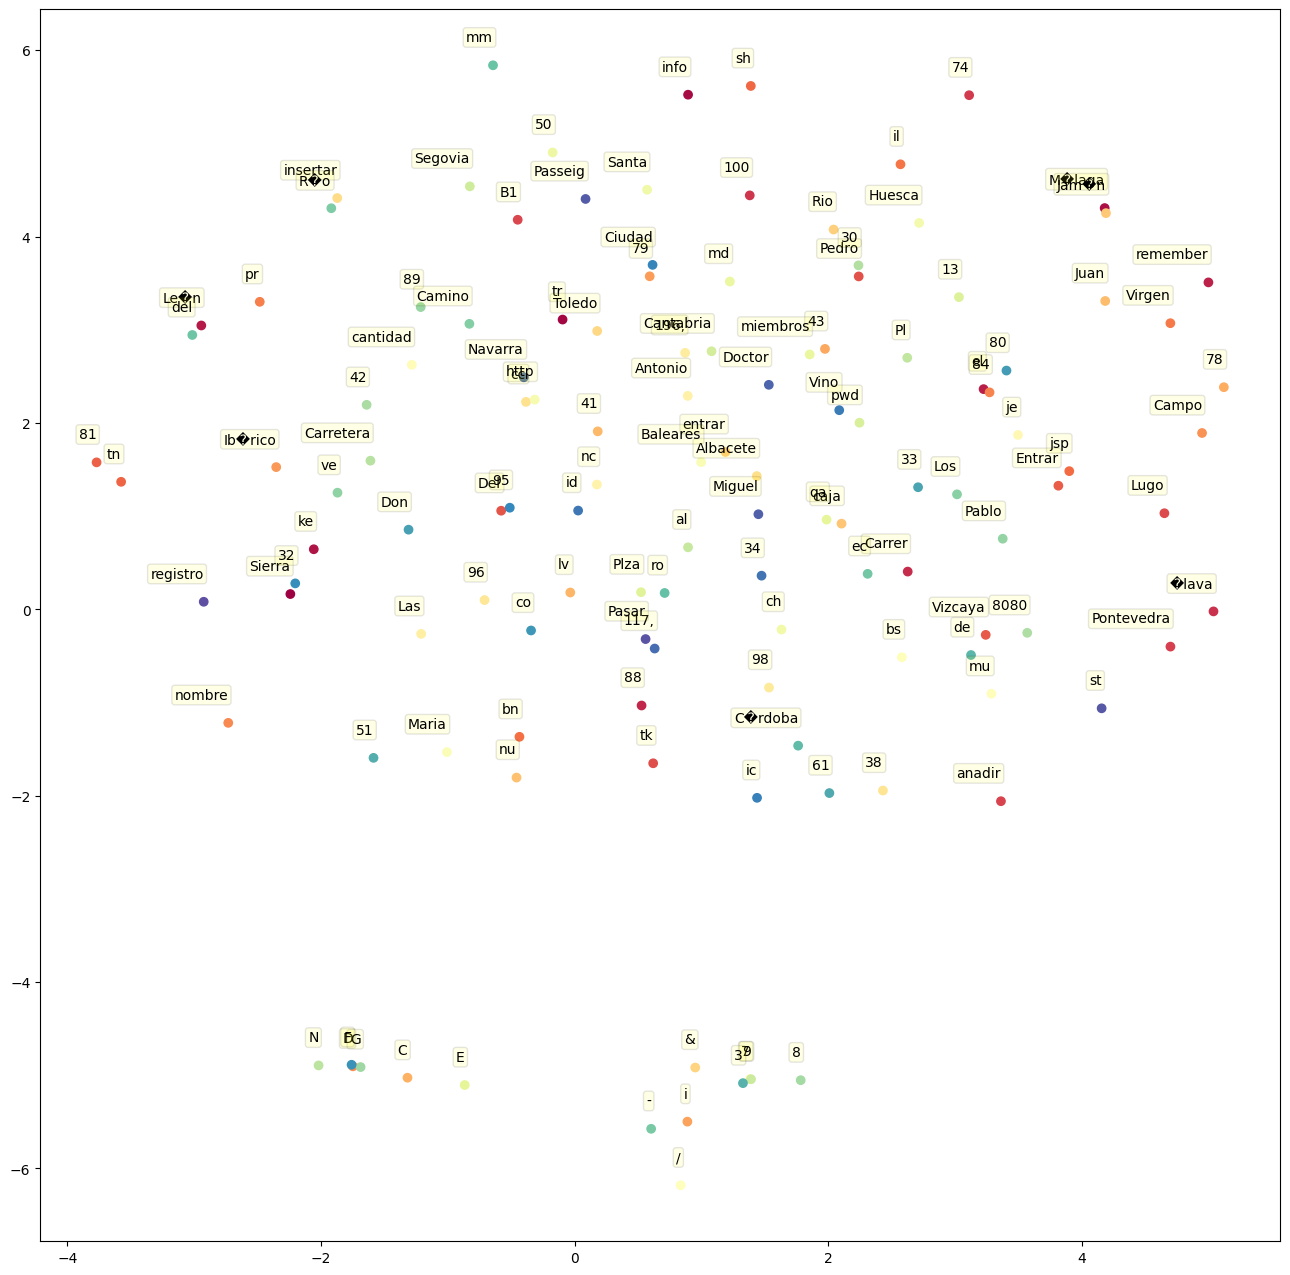

In [207]:
def token2word(token):
    return w2v_model.wv.index_to_key[token]

n_samples = 128
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([w2v_model.wv[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

plt.figure(figsize=(16, 16))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

In [209]:
#  prepare embedding matrix
vocab_size = 10000
embedding_dim = 128
max_length = 120

# tokenize
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(normal_sentence)
train_sequences = tokenizer.texts_to_sequences(train_normal_data)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_sequences = tokenizer.texts_to_sequences(test_normal_data)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

#add dimension in train_padded
train_padded = np.expand_dims(train_padded, axis=2)
test_padded = np.expand_dims(test_padded, axis=2)
# create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    try:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), embedding_dim)

embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))